## This script introduces Diffusion Posterior Sampling reconstruction using CTorch

Reference: Jiang, Xiao, Shudong Li, Peiqing Teng, Grace Gang, and J. Webster Stayman. "Strategies for CT Reconstruction using Diffusion Posterior Sampling with a Nonlinear Model." ArXiv (2024): arXiv-2407.

#### Import python package 

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import torch
import gdown
import math

plt.style.use("dark_background")
plt.rcParams['image.cmap'] = 'gray'

#### Import CTorch package 

In [2]:
import CTorch.utils.geometry as geometry
from CTorch.reconstructor.fbpreconstructor import FBPReconstructor  as FBP
from CTorch.projector.projector_interface import Projector

#### [Import Diffusers package](https://github.com/huggingface/diffusers) 

In [3]:
from diffusers import UNet2DModel
from diffusers import DDPMScheduler

#### Define [geometry](./2_geometry.ipynb)

In [4]:
nx, ny = 512,512 # image dimension
dx, dy = 0.8, 0.8 # image pixel size

nu = 1024 # detector length 
du = 1.0 # detecor pixel size
nView = 720 # number of views
viewAngles = np.arange(0,-2*np.pi,-2*np.pi/nView) # projection angle
detType = 'curve' #'curve'
SAD, SDD = [800.0], [1200.0] # source-axis-distance, source-detector-distance

xOfst, yOfst = [0.0], [0.0] # image center offset
uOfst = [0.0] # detecor center offset
xSrc = [100.0]

# define geometry object
geom = geometry.Geom2D(nx, ny, dx, dy, nu, nView, viewAngles, du, detType, SAD, SDD, 
                 xOfst = xOfst, yOfst = yOfst, uOfst = uOfst, xSrc = xSrc, fixed=True)  


#### Define [projector](./3_projector.ipynb)

In [5]:
# define projector
A = Projector(geom,'proj','SF','forward')
recon = FBP(geom,'SF',window="hamming")

#### Load example data

In [6]:
img = io.loadmat("img_example.mat")["img"].T
img = torch.Tensor(img).reshape([1,1,ny,nx]).cuda()

#### Projection simulation

In [7]:
I0 = 1e4
proj = torch.poisson(I0*torch.exp(-A(img)))
sino = math.log(I0) - torch.log(proj)
img_FBP = recon(sino)

#### Configure score network and DDPM noise scheduler

In [8]:
## Score net configuration
nc = 16
unet_config = {"sample_size": 512, "in_channels": 1, "out_channels":1, 
               "layers_per_block": 1, "block_out_channels": 
                  (nc, nc*2, nc*4, nc*8, nc*16, nc*32, nc*32),
               "down_block_types": ("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D",
                                    "DownBlock2D", "DownBlock2D", "DownBlock2D"),
                "up_block_types": (
                   "UpBlock2D", "UpBlock2D", "UpBlock2D", 
                   "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
                "norm_num_groups": 1}

## DDPM noise scheduler
scheduler_config = {"beta_start": 1e-4, "beta_end": 2e-2, 
                    "clip_sample": 10.0, "num_train_timesteps": 1000}

normalize_weight = 0.04

In [9]:
file_id = "1fTLP1gCIcS9KJpG7L8b5OlixS7aAAvlG"
destination = "model_weights.pth"  # Change this to your preferred filename
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fTLP1gCIcS9KJpG7L8b5OlixS7aAAvlG
From (redirected): https://drive.google.com/uc?id=1fTLP1gCIcS9KJpG7L8b5OlixS7aAAvlG&confirm=t&uuid=aaaf2e1c-45a1-408f-be5f-542472894d68
To: c:\Users\xjiang43\work\code\github\AIAI-CTorch\example\model_weights.pth
100%|██████████| 255M/255M [00:05<00:00, 48.1MB/s] 


'model_weights.pth'

In [10]:
model = UNet2DModel(**unet_config).cuda()
model.load_state_dict(torch.load(destination))
model.eval()

scheduler = DDPMScheduler(**scheduler_config)

C:\Users\xjiang43\AppData\Local\Temp\ipykernel_17296\1480681432.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(destination))


In [11]:
def DPS(img_init,js_steps,lr,num_iteration,num_subset):
    A = Projector(geom,'proj','SF','forward',subset=num_subset)   
    statictic_weight = 1.0/proj 
    
    # Jumpstart
    noise = torch.randn_like(img_init)
    img = torch.Tensor(img_init).cuda()/normalize_weight
    img = scheduler.add_noise(img, noise, torch.Tensor([js_steps-1]).cuda().long())
    
    x = torch.zeros_like(img).requires_grad_(True)
    optimizer = torch.optim.Adam([x], lr=lr)
    
    # Reverse sampling
    for t in scheduler.timesteps[(1000-js_steps):]:            
        prev_t = t - 1
        alpha_prod_t = scheduler.alphas_cumprod[t]
        alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        with torch.no_grad():
            noisy_residual = model(img,t).sample  
            x0 = (img - beta_prod_t ** (0.5) * noisy_residual) / alpha_prod_t ** (0.5) 
        
        x.data = x0*normalize_weight
        for _ in range(num_iteration):
            proj_pred = I0*torch.exp(-A(x))
            
            loss = torch.mean((proj_pred-
                               proj[...,(A.subset_id+num_subset-1)%num_subset::num_subset,:])**2
                              *statictic_weight[...,(A.subset_id+num_subset-1)%num_subset::num_subset,:])
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            w0 = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t      
            w1 = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
            
            variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
            variance = torch.clamp(variance, min=1e-20)
            img = x0*w0 + img*w1 + torch.randn_like(img)*(variance**0.5)

            img = img - (x0 - x/normalize_weight)
        
        print(f"Step {t.item()} completed, loss: {loss.item()}")

    return img*normalize_weight

In [12]:
img_DPS = DPS(img_FBP,50,1e-3,2,2)

c:\Users\xjiang43\AppData\Local\anaconda3\envs\install\Lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


Step 49 completed, loss: 126.71773529052734
Step 48 completed, loss: 56.07785415649414
Step 47 completed, loss: 1.6801639795303345
Step 46 completed, loss: 6.23225736618042
Step 45 completed, loss: 3.9597272872924805
Step 44 completed, loss: 1.3958957195281982
Step 43 completed, loss: 3.0850911140441895
Step 42 completed, loss: 1.269092082977295
Step 41 completed, loss: 1.6811684370040894
Step 40 completed, loss: 1.552671194076538
Step 39 completed, loss: 1.207200288772583
Step 38 completed, loss: 1.3988583087921143
Step 37 completed, loss: 1.1273740530014038
Step 36 completed, loss: 1.2297260761260986
Step 35 completed, loss: 1.1110880374908447
Step 34 completed, loss: 1.101759910583496
Step 33 completed, loss: 1.1072527170181274
Step 32 completed, loss: 1.0654295682907104
Step 31 completed, loss: 1.0791854858398438
Step 30 completed, loss: 1.0523380041122437
Step 29 completed, loss: 1.0570147037506104
Step 28 completed, loss: 1.0467872619628906
Step 27 completed, loss: 1.046314358711

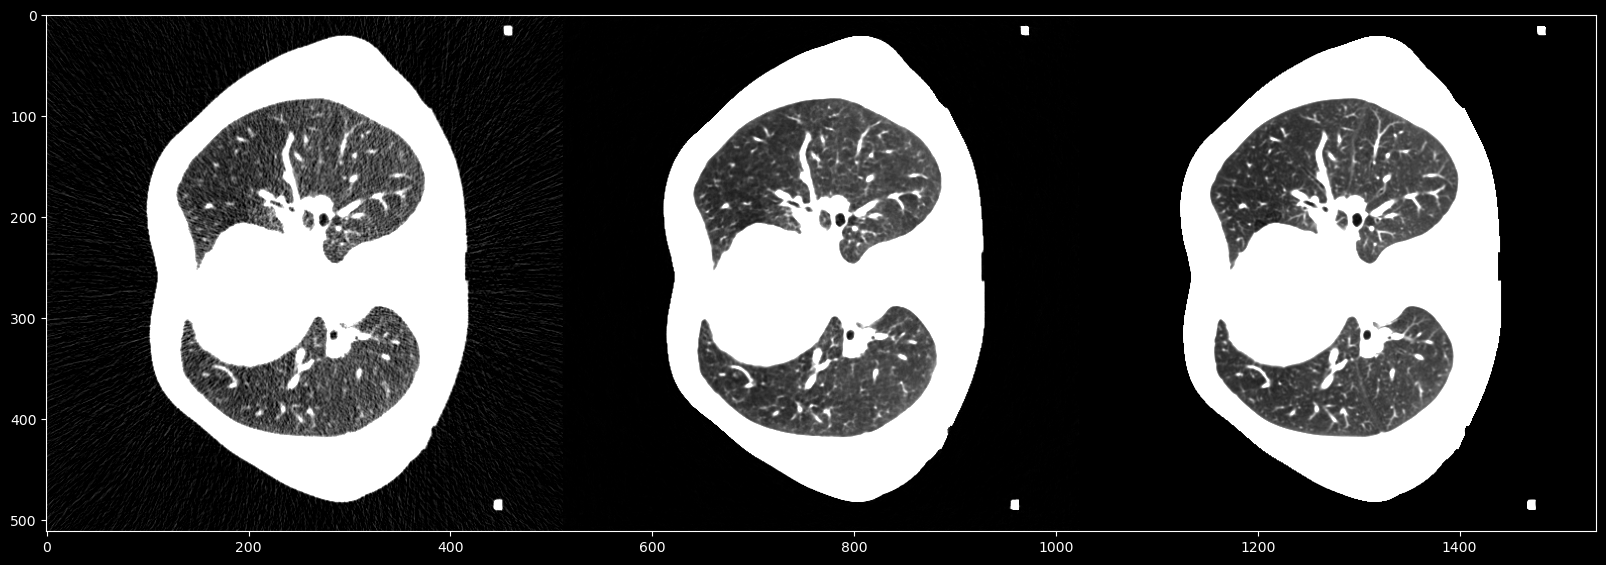

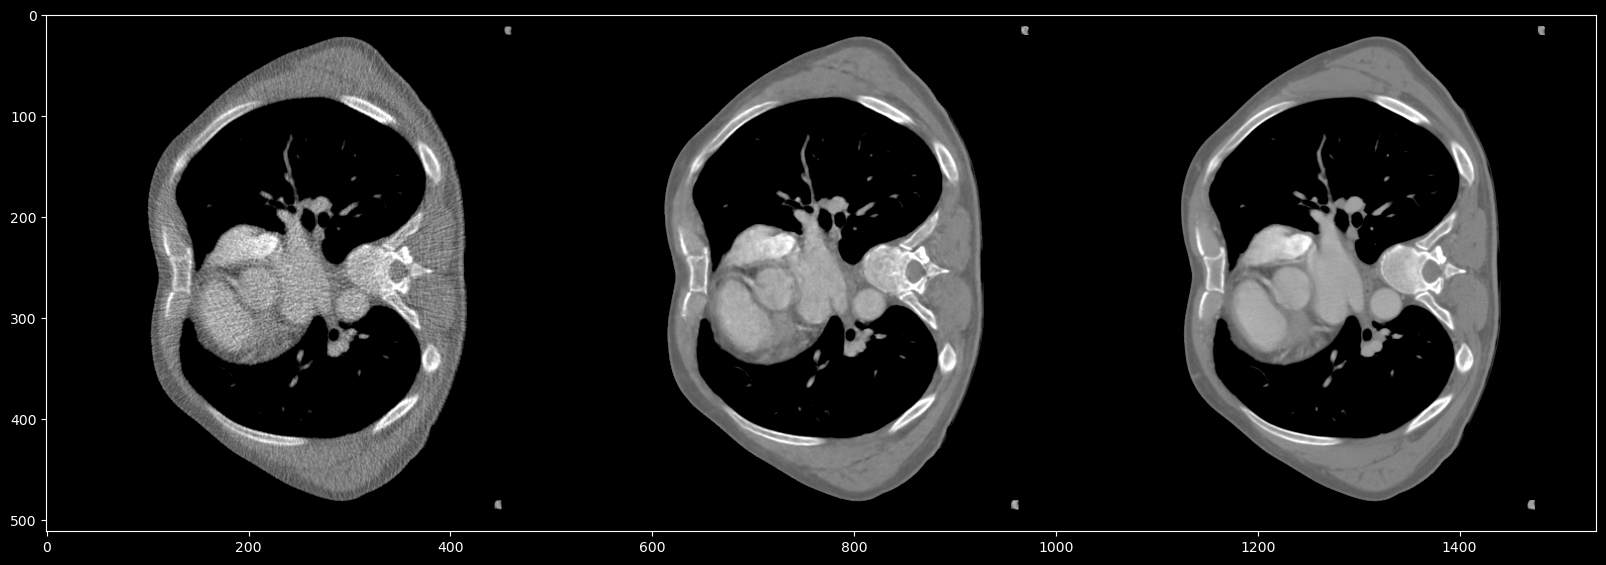

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(torch.hstack([img_FBP[0,0],img_DPS[0,0],img[0,0]]).cpu().detach(),
           cmap="gray", vmin=0.00, vmax=0.01)

plt.figure(figsize=(20,20))
plt.imshow(torch.hstack([img_FBP[0,0],img_DPS[0,0],img[0,0]]).cpu().detach(),
           cmap="gray", vmin=0.01, vmax=0.03)